Install HPI tool and get trainings-data

In [1]:
%tensorflow_version 2.x # Befehl für Google Colab für Tensorflow 2

# ohne Ausrufezeichen bei Ausführung im lokalen Notebook
!pip install --upgrade deeplearning2020
from deeplearning2020.datasets import ImageWoof

train_data, test_data, classes = ImageWoof.load_data()

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Befehl für Google Colab für Tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
     |████████████████████████████████| 399kB 4.6MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.21-py2.py3-none-any.whl size=8548 sha256=3c08527f9da346be4d5ba1f267b71083a8da87e8f550aa88c59ca568b62bc342
  Stored in directory: /root/.cache/pip/wheels/7f/c2/8a/f9f03fc839999f1fe9d5e5a9d2c97cdd5cb8329f61f82ea2c9
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=62dd5af35352da70951f75c313d467e9c18e6e509876bc41c609891584727925
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission
328294400/328288506 [==============================] - 3s 0us/step
/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.

Init *Tensorflow* and stuff

In [2]:
# TensorFlow ≥2.0 wird benötigt
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
  print("GPU ok")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, \
  Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
%matplotlib inline

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU ok


Ok, take helpers, too

In [0]:
from deeplearning2020 import helpers

#helpers.plot_images(train_data_orig.take(9), classes)

Define the preprocessor

In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [300, 300])
    return resized_image, label

Resize the pictures and prepare batch

In [6]:
# Festlegung der Batch Größe für die Datenvorbereitung
batch_size = 32 

# Durchmischen der Trainingsdaten, dass nicht mit sortierten Bildern trainiert wird 
train_data = train_data.shuffle(1000) 

print('shape des Trainigsdatensatzes vor dem preprocessing: ', train_data)

train_data = train_data.map(preprocess) \
  .batch(batch_size).prefetch(1)          
test_data = test_data.map(preprocess) \
  .batch(batch_size).prefetch(1)

print('shape des Traingingsdatensatzes nach dem preprocessing: ', train_data)

shape des Trainigsdatensatzes vor dem preprocessing:  <ShuffleDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
shape des Traingingsdatensatzes nach dem preprocessing:  <PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


Show train data

In [0]:
#helpers.plot_images(train_data.unbatch().take(9), classes)

Define the net

In [12]:
# model
learning_rate=0.003
momentum=0.9
dense_neurons=1000
n_filters=512
first_kernel_size=(11,11)

n_classes=len(classes)

activation='elu'

# Inputgröße muss 300x300 Pixel mit 3 RGB Farben betragen
input_layer = Input(shape=(300, 300, 3))

# Convolutional Neural Network
# 6 Convolutional Layers mit jeweils einer Max Pooling Layer
model = Conv2D(
    filters=256,
    kernel_size=first_kernel_size,
    activation=activation
)(input_layer)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = 256, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(filters = n_filters, 
  kernel_size=(3,3), 
  activation=activation, 
  padding='same'
)(model)
model = MaxPooling2D((2,2))(model)

# Fully-Connected-Classifier
model = Flatten()(model)
model = Dense(
    dense_neurons,
    activation=activation
)(model)

model = Dense(
    dense_neurons / 2,
    activation='tanh'
)(model)

# Output Layer
output = Dense(n_classes, activation="softmax")(model)

CNN_model = Model(input_layer, output)

# Kompilieren des Modells
## Stochastic Gradient Descent -> langsamer aber genauer
optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
## Adam -> schneller, für schnellere aber nicht 100% Ergebnisse
#optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
CNN_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)
CNN_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 290, 290, 256)     93184     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 145, 145, 256)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 143, 143, 256)     590080    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 69, 69, 512)       1180160   
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 34, 34, 512)       0   

Training

In [17]:
# Training des Modells
history = CNN_model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)

Epoch 1/10
283/283 [==============================] - 141s 499ms/step - loss: 1.7890 - accuracy: 0.3659 - val_loss: 1.9787 - val_accuracy: 0.3207
Epoch 2/10
283/283 [==============================] - 141s 500ms/step - loss: 1.6319 - accuracy: 0.4311 - val_loss: 1.7655 - val_accuracy: 0.3963
Epoch 3/10
283/283 [==============================] - 141s 500ms/step - loss: 1.4003 - accuracy: 0.5151 - val_loss: 1.9854 - val_accuracy: 0.3607
Epoch 4/10
283/283 [==============================] - 141s 499ms/step - loss: 1.0956 - accuracy: 0.6325 - val_loss: 2.1830 - val_accuracy: 0.3535
Epoch 5/10
283/283 [==============================] - 142s 500ms/step - loss: 0.8397 - accuracy: 0.7160 - val_loss: 2.3054 - val_accuracy: 0.3747
Epoch 6/10
283/283 [==============================] - 141s 499ms/step - loss: 0.2364 - accuracy: 0.9314 - val_loss: 2.3615 - val_accuracy: 0.4082
Epoch 7/10
283/283 [==============================] - 141s 499ms/step - loss: 0.0481 - accuracy: 0.9924 - val_loss: 2.4178 -

Tranings-Ergebnis anzeigen

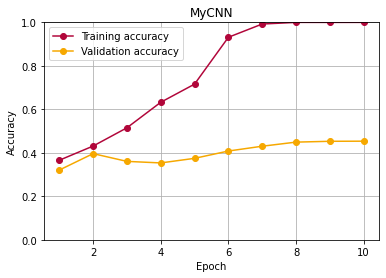

In [18]:
helpers.plot_history('MyCNN', history, 0)

Submission

In [19]:
from deeplearning2020 import Submission
Submission('4d712a6d0ae14f2a395c992ad3627476', '3', CNN_model).submit()

Model wird validiert...


100% (200 of 200) |######################| Elapsed Time: 0:09:27 Time:  0:09:27


Assignment 3 erfolgreich abgegeben!
Dein Model hat eine Accuracy von 46.0% auf unseren Validierungsdaten.
Du erhältst 48.0% der Punkte auf dieses Assignment.
Falls du bereits eine Abgabe mit höherer Bewertung abgegeben hast, wird automatisch das bessere Ergebnis gewählt.
